In [74]:
import os
import pickle
import numpy as np
import pandas as pd
import random
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ✅ Load Data Paths
DATA_FILE = "data/synth_findata.csv"
METRICS_FILE = "saved_models/Model_Performance_Metrics_Updated.csv"
MODEL_DIR = "saved_models/"

# ✅ Load synthetic data
df = pd.read_csv(DATA_FILE)

# ✅ Preprocess Data
def preprocess_data(df):
    df = df.copy()
    
    # Convert date columns to timestamps (if applicable)
    for col in df.select_dtypes(include=['object']):
        try:
            df[col] = pd.to_datetime(df[col]).astype(int) / 10**9  # Convert to timestamp
        except:
            df[col] = df[col].astype("category").cat.codes  # Convert categories to numerical codes

    # Fill missing values
    df.fillna(df.median(), inplace=True)
    
    return df

df = preprocess_data(df)

# ✅ Separate Features & Target
X = df.drop(columns=["market_stress"])
y = df["market_stress"]

# ✅ Standardize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ✅ Recreate NEATModelWrapper class before loading models
class NEATModelWrapper:
    """Wrapper to make NEAT behave like a scikit-learn model."""
    def __init__(self, genome, config):
        self.genome = genome
        self.config = config
        self.net = neat.nn.FeedForwardNetwork.create(genome, config)

    def predict_proba(self, X):
        """Returns probability predictions (like logistic regression)."""
        X = np.array(X)
        return np.array([[1 - self.net.activate(xi)[0], self.net.activate(xi)[0]] for xi in X])  # [prob_0, prob_1]

    def predict(self, X):
        """Returns binary predictions (0 or 1)."""
        return np.argmax(self.predict_proba(X), axis=1)  # Take class with highest probability

# ✅ Load Models
model_files = {
    "Elastic Net": "Elastic Net.pkl",
    "SGD": "SGD.pkl",
    "Gradient Boosting": "Gradient Boosting.pkl",
    "CNN (MLP)": "CNN (MLP).pkl",
    "Diffusion Model": "Diffusion Model.pkl",
    "GA-Optimized LR": "GA-Optimized LR.pkl",
    "NeuroEvolution (NEAT)": "NeuroEvolution (NEAT).pkl",
}
models = {}
for name, file in model_files.items():
    try:
        with open(os.path.join(MODEL_DIR, file), "rb") as f:
            models[name] = pickle.load(f)
            print(f"✅ Loaded Model: {name}")
    except Exception as e:
        print(f"❌ Failed to load {name}: {e}")

# ✅ Load Performance Metrics
df_metrics = pd.read_csv(METRICS_FILE)

# ✅ Model Battle Function

def adjust_features(X, model):
    """Dynamically adjust X to match the expected input size of a model."""
    expected_features = getattr(model, "n_features_in_", X.shape[1])

    if X.shape[1] < expected_features:
        # If X has fewer features, pad with zeros
        padding = np.zeros((X.shape[0], expected_features - X.shape[1]))
        X_adjusted = np.hstack((X, padding))
        print(f"⚠️ Adding {expected_features - X.shape[1]} dummy columns to match model input size.")
    elif X.shape[1] > expected_features:
        # If X has more features, remove extra columns
        X_adjusted = X[:, :expected_features]
        print(f"⚠️ Reducing {X.shape[1] - expected_features} features to match model input size.")
    else:
        X_adjusted = X  # No adjustment needed

    return X_adjusted

def model_battle(model_1, model_2, X, y):
    """Models compete by predicting market stress and betting confidence."""
    X1 = adjust_features(X, model_1)
    X2 = adjust_features(X, model_2)

    pred_1 = model_1.predict(X1)
    pred_2 = model_2.predict(X2)

    conf_1 = np.mean((pred_1 > 0.5) == y) * np.mean(np.abs(pred_1 - 0.5))
    conf_2 = np.mean((pred_2 > 0.5) == y) * np.mean(np.abs(pred_2 - 0.5))

    return (model_1, model_2) if conf_1 > conf_2 else (model_2, model_1)

def breed_models(parent_1, parent_2, mutation_rate=0.1):
    """Hybrid model by blending numeric parameters & inheriting non-numeric ones."""
    if not hasattr(parent_1, "get_params") or not hasattr(parent_2, "get_params"):
        return random.choice([parent_1, parent_2])  # If not compatible, pick one

    parent_1_params = parent_1.get_params()
    parent_2_params = parent_2.get_params()
    hybrid_params = {}

    for param in parent_1_params:
        if param in parent_2_params:
            val1 = parent_1_params[param]
            val2 = parent_2_params[param]

            try:
                # If both are numeric, average and apply mutation
                new_val = (float(val1) + float(val2)) / 2
                if random.random() < mutation_rate:
                    new_val *= random.uniform(0.9, 1.1)
                hybrid_params[param] = new_val
            except (ValueError, TypeError):
                # Otherwise randomly inherit one of the values
                hybrid_params[param] = random.choice([val1, val2])
        else:
            hybrid_params[param] = parent_1_params[param]

    try:
        hybrid_model = type(parent_1)(**hybrid_params)
        return hybrid_model
    except Exception as e:
        print(f"⚠️ Failed to create hybrid: {e}")
        return random.choice([parent_1, parent_2])

# # ✅ Breeding Function
# def breed_models(parent_1, parent_2, mutation_rate=0.1):
#     """Hybrid model by blending parameters & mutations."""
#     if not hasattr(parent_1, "get_params") or not hasattr(parent_2, "get_params"):
#         return random.choice([parent_1, parent_2])  # If not compatible, pick one

#     parent_1_params = parent_1.get_params()
#     parent_2_params = parent_2.get_params()
#     hybrid_params = {}

#     for param in parent_1_params:
#         if param in parent_2_params:
#             hybrid_params[param] = (parent_1_params[param] + parent_2_params[param]) / 2
#             if random.random() < mutation_rate:
#                 hybrid_params[param] *= random.uniform(0.9, 1.1)
#         else:
#             hybrid_params[param] = parent_1_params[param]
    
#     try:
#         hybrid_model = type(parent_1)(**hybrid_params)
#         return hybrid_model
#     except:
#         return random.choice([parent_1, parent_2])  # If error, return a parent

# ✅ Family tree tracking
family_tree = {}

✅ Loaded Model: Elastic Net
✅ Loaded Model: SGD
✅ Loaded Model: Gradient Boosting
✅ Loaded Model: CNN (MLP)
✅ Loaded Model: Diffusion Model
✅ Loaded Model: GA-Optimized LR
✅ Loaded Model: NeuroEvolution (NEAT)


In [76]:
import string  # Make sure this is at the top for `string.ascii_lowercase`

# 🧬 Ancestry & Clan Tracking
model_lineage = {}     # Tracks generation depth + family/clan for each model
used_clan_names = set()  # Keep track of unique family names

def generate_clan_name(parents):
    """Generates a unique clan/family name from parent model names."""
    base_name = "_".join(sorted([p.split()[0].lower() for p in parents])).replace("(", "").replace(")", "")
    while True:
        suffix = ''.join(random.choices(string.ascii_lowercase, k=4))
        clan_name = f"Clan_{base_name}_{suffix}"
        if clan_name not in used_clan_names:
            used_clan_names.add(clan_name)
            return clan_name

def get_family(model_name):
    """Returns the family (clan) of a model, if it exists."""
    return model_lineage.get(model_name, {}).get("family", None)

def get_depth(model_name):
    """Returns the ancestry depth of a model, defaulting to 0."""
    return model_lineage.get(model_name, {}).get("depth", 0)

In [92]:
# def log_hybrid(child_name, parent1, parent2, gen, lifespan):
#     family_tree[child_name] = {
#         "generation": gen,
#         "parents": (parent1, parent2)
#     }
#     print(f"🧬 Created Hybrid Model: {child_name}")
#     print(f"     ├─ Parents: {parent1} + {parent2}")
#     print(f"     ├─ Generation: {gen}")
#     print(f"     └─ Lifespan: {lifespan}")'

# def log_hybrid(child_name, parent1, parent2, gen, lifespan):
#     family = model_lineage.get(child_name, {}).get("family")
#     print(f"🧬 Created Hybrid Model: {child_name}")
#     print(f"     ├─ Parents: {parent1} + {parent2}")
#     print(f"     ├─ Generation: {gen}")
#     print(f"     ├─ Lifespan: {lifespan}")
#     if family:
#         print(f"     └─ Family: {family}")

# family_tree[child_name] = {
#     "generation": gen,
#     "parents": (parent1, parent2)
# }

def log_hybrid(child_name, parent1, parent2, gen, lifespan):
    # Add to family tree dictionary
    family_tree[child_name] = {
        "generation": gen,
        "parents": (parent1, parent2)
    }

    # Optional lineage printout
    family = model_lineage.get(child_name, {}).get("family")
    print(f"🧬 Created Hybrid Model: {child_name}")
    print(f"     ├─ Parents: {parent1} + {parent2}")
    print(f"     ├─ Generation: {gen}")
    print(f"     ├─ Lifespan: {lifespan}")
    if family:
        print(f"     └─ Family: {family}")

# ✅ Evolution Function
# def evolve_models(models, X, y, generations=3, lifespan=3):
#     """Runs evolution over multiple generations with lifespan tracking."""
    
#     # ✅ Ensure models are stored as {model_name: (model_object, lifespan)}
#     population = {name: (model, lifespan) for name, model in models.items()}

#     for gen in range(generations):
#         print(f"\n🚀 **Generation {gen+1}: Running Evolution**")
        
#         model_names = list(population.keys())
#         random.shuffle(model_names)
#         survivors = {}

#         # ✅ Battle Phase: Models compete, and winners survive
#         for i in range(0, len(model_names), 2):
#             if i + 1 < len(model_names):
#                 winner_name, loser_name = model_battle(population[model_names[i]][0], 
#                                                        population[model_names[i+1]][0], X, y)
#                 if winner_name in population:  # ✅ Ensure the winner exists
#                     survivors[winner_name] = (population[winner_name][0], population[winner_name][1] - 1)
#             else:
#                 survivors[model_names[i]] = (population[model_names[i]][0], population[model_names[i]][1] - 1)

#         # ✅ Remove expired models (lifespan reaches 0)
#         survivors = {k: v for k, v in survivors.items() if v[1] > 0}

#         # ✅ Performance-Based Selection (Top 2 from metrics)
#         top_models = df_metrics.sort_values(by="Fitness Score", ascending=False).head(2)["Model"].values
#         for top_model in top_models:
#             top_model_str = str(top_model)  # Ensure model name is a string
#             if top_model_str in models:
#                 survivors[top_model_str] = (models[top_model_str], lifespan)  # Reset lifespan

#         # ✅ Breeding Phase: Create hybrids with a slight mutation advantage
#         offspring = {}
#         survivor_names = list(survivors.keys())
#         for i in range(0, len(survivor_names), 2):
#             if i + 1 < len(survivor_names):
#                 parent_1, parent_2 = survivors[survivor_names[i]][0], survivors[survivor_names[i+1]][0]
#                 child = breed_models(parent_1, parent_2)
#                 child_name = f"Hybrid_{survivor_names[i]}_{survivor_names[i+1]}_Gen{gen+1}"
#                 offspring[child_name] = (child, lifespan)

#         # ✅ Update population with survivors + offspring
#         population = {**survivors, **offspring}
#         print(f"✅ Survivors: {len(survivors)} advancing. {len(offspring)} new hybrids created.")

#     return population



# def evolve_models(models, X, y, generations=3, lifespan=3):
#     """Runs evolution over multiple generations with lifespan tracking & metrics saving."""

#     # ✅ Store models as {model_name: (model_object, lifespan, metrics)}
#     population = {name: (model, lifespan, df_metrics[df_metrics["Model"] == name].iloc[0].to_dict()) 
#                   for name, model in models.items()}

#     all_results = []  # ✅ Store full evolution history

#     for gen in range(generations):
#         print(f"\n🚀 **Generation {gen+1}: Running Evolution**")
        
#         model_names = list(population.keys())
#         random.shuffle(model_names)
#         survivors = {}

#         # ✅ Battle Phase: Models compete, winners survive
#         for i in range(0, len(model_names), 2):
#             if i + 1 < len(model_names):
#                 winner_name, loser_name = model_battle(population[model_names[i]][0], 
#                                                        population[model_names[i+1]][0], X, y)
#                 if winner_name in population:
#                     survivors[winner_name] = (population[winner_name][0], 
#                                               population[winner_name][1] - 1, 
#                                               population[winner_name][2])  # Keep metrics

#         # ✅ Remove expired models
#         survivors = {k: v for k, v in survivors.items() if v[1] > 0}

#         # ✅ Performance-Based Selection
#         top_models = df_metrics.sort_values(by="Fitness Score", ascending=False).head(2)["Model"].values
#         for top_model in top_models:
#             top_model_str = str(top_model)
#             if top_model_str in models:
#                 survivors[top_model_str] = (models[top_model_str], lifespan, 
#                                             df_metrics[df_metrics["Model"] == top_model_str].iloc[0].to_dict())

#         # ✅ Breeding Phase
#         offspring = {}
#         survivor_names = list(survivors.keys())
#         for i in range(0, len(survivor_names), 2):
#             if i + 1 < len(survivor_names):
#                 parent_1, parent_2 = survivors[survivor_names[i]], survivors[survivor_names[i+1]]
#                 child = breed_models(parent_1[0], parent_2[0])

#                 # ✅ Compute Hybrid Metrics (Ensure Numeric Type)
#                 hybrid_metrics = {}
#                 for metric in df_metrics.columns[1:]:  # Exclude 'Model' column
#                     try:
#                         hybrid_metrics[metric] = (float(parent_1[2][metric]) + float(parent_2[2][metric])) / 2
#                         hybrid_metrics[metric] *= random.uniform(0.95, 1.05)  # Mutation factor
#                     except ValueError:
#                         hybrid_metrics[metric] = "Hybrid"  # If not numeric, just tag it
                
#                 child_name = f"Hybrid_{survivor_names[i]}_{survivor_names[i+1]}_Gen{gen+1}"
#                 offspring[child_name] = (child, lifespan, hybrid_metrics)

#         # ✅ Save Current Generation Metrics
#         for name, (_, _, metrics) in {**survivors, **offspring}.items():
#             all_results.append({"Generation": f"{gen+1}", "Model Name": name, "Lineage": f"Gen{gen+1}-{name}", **metrics})

#         # ✅ Update Population
#         population = {**survivors, **offspring}
#         print(f"✅ Survivors: {len(survivors)} advancing. {len(offspring)} new hybrids created.")

#     # ✅ Convert to DataFrame & Save
#     df_evolution = pd.DataFrame(all_results)

#     # **Ensure all numeric columns are properly formatted**
#     numeric_cols = df_metrics.columns[1:]
#     for col in numeric_cols:
#         df_evolution[col] = pd.to_numeric(df_evolution[col], errors="coerce")  # Convert safely

#     timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
#     df_evolution.to_csv(os.path.join(MODEL_DIR, f"Model_Performance_Metrics_{timestamp}.csv"), index=False)
    
#     print(f"\n✅ Evolution Complete! Performance data saved as: Model_Performance_Metrics_{timestamp}.csv")

#     return population





def evolve_models(models, X, y, generations=50, lifespan=3):
    """Runs evolution over multiple generations with lifespan tracking & full metrics saving."""

    # ✅ Store models as {model_name: (model_object, lifespan, metrics)}
    population = {name: (model, lifespan, df_metrics[df_metrics["Model"] == name].iloc[0].to_dict()) 
                  for name, model in models.items()}

    all_results = []  # ✅ Store full evolution history

    for gen in range(generations):
        print(f"\n🚀 **Generation {gen+1}: Running Evolution**")
        
        model_names = list(population.keys())
        random.shuffle(model_names)
        survivors = {}

        # ✅ Battle Phase: Models compete, winners survive
        for i in range(0, len(model_names), 2):
            if i + 1 < len(model_names):
                winner_name, loser_name = model_battle(population[model_names[i]][0], 
                                                       population[model_names[i+1]][0], X, y)
                if winner_name in population:
                    survivors[winner_name] = (population[winner_name][0], 
                                              population[winner_name][1] - 1, 
                                              population[winner_name][2])  # Keep metrics

        # ✅ Remove expired models
        survivors = {k: v for k, v in survivors.items() if v[1] > 0}

        # ✅ Performance-Based Selection
        top_models = df_metrics.sort_values(by="Fitness Score", ascending=False).head(2)["Model"].values
        # top_models = random.sample(list(models.keys()), 4)  # or pick top 2 + 2 random
        # for top_model in top_models:
        #     top_model_str = str(top_model)
        #     if top_model_str in models:
        #         survivors[top_model_str] = (models[top_model_str], lifespan, 
        #                                     df_metrics[df_metrics["Model"] == top_model_str].iloc[0].to_dict())
        for top_model in top_models:
            top_model_str = str(top_model)
            if top_model_str in population:
                survivors[top_model_str] = population[top_model_str]  # reuse current instance, not base model

        # # ✅ Breeding Phase
        # offspring = {}
        # survivor_names = list(survivors.keys())
        # for i in range(0, len(survivor_names), 2):
        #     if i + 1 < len(survivor_names):
        #         parent_1, parent_2 = survivors[survivor_names[i]], survivors[survivor_names[i+1]]
        #         child = breed_models(parent_1[0], parent_2[0])

        #         # ✅ Compute Hybrid Metrics (Ensure Numeric Type)
        #         hybrid_metrics = {}
        #         for metric in df_metrics.columns[1:]:  # Exclude 'Model' column
        #             try:
        #                 hybrid_metrics[metric] = (float(parent_1[2].get(metric, 0.0)) + float(parent_2[2].get(metric, 0.0))) / 2
        #                 hybrid_metrics[metric] *= random.uniform(0.95, 1.05)  # Mutation factor
        #             except ValueError:
        #                 hybrid_metrics[metric] = "Hybrid"  # If not numeric, just tag it
                
        #         child_name = f"Hybrid_{survivor_names[i]}_{survivor_names[i+1]}_Gen{gen+1}"
        #         offspring[child_name] = (child, lifespan, hybrid_metrics)
        #         # log_hybrid(child_name, survivor_names[i], survivor_names[i+1], gen+1)
        #         log_hybrid(child_name, survivor_names[i], survivor_names[i+1], gen+1, lifespan)

        # ✅ Breeding Phase with Diversity Guardrails
        # offspring = {}
        # used_pairs = set()
        # survivor_names = list(survivors.keys())
        
        # for i in range(0, len(survivor_names), 2):
        #     if i + 1 < len(survivor_names):
        #         parent1_name = survivor_names[i]
        #         parent2_name = survivor_names[i+1]
        #         pair_key = tuple(sorted([parent1_name, parent2_name]))
        
        #         # Skip if this exact pair already bred
        #         if pair_key in used_pairs:
        #             continue
        
        #         parent_1, parent_2 = survivors[parent1_name], survivors[parent2_name]
        #         child = breed_models(parent_1[0], parent_2[0])
        
        #         # ✅ Compute Hybrid Metrics
        #         hybrid_metrics = {}
        #         for metric in df_metrics.columns[1:]:
        #             try:
        #                 hybrid_metrics[metric] = (
        #                     float(parent_1[2].get(metric, 0.0)) + float(parent_2[2].get(metric, 0.0))
        #                 ) / 2 * random.uniform(0.95, 1.05)
        #             except ValueError:
        #                 hybrid_metrics[metric] = "Hybrid"
        
        #         child_name = f"Hybrid_{parent1_name}_{parent2_name}_Gen{gen+1}"
        #         offspring[child_name] = (child, lifespan, hybrid_metrics)
        #         used_pairs.add(pair_key)
        
        #         log_hybrid(child_name, parent1_name, parent2_name, gen + 1, lifespan)
        # ✅ Breeding Phase with Diversity Guardrails & Clan Assignment
        offspring = {}
        used_pairs = set()
        survivor_names = list(survivors.keys())
        
        for i in range(0, len(survivor_names), 2):
            if i + 1 < len(survivor_names):
                parent1 = survivor_names[i]
                parent2 = survivor_names[i+1]
                pair_key = tuple(sorted([parent1, parent2]))
        
                # 🛑 Prevent intra-family breeding if both have same family
                if get_family(parent1) and get_family(parent1) == get_family(parent2):
                    continue
        
                if pair_key in used_pairs:
                    continue
        
                parent_1, parent_2 = survivors[parent1], survivors[parent2]
                child = breed_models(parent_1[0], parent_2[0])
        
                child_name = f"Hybrid_{parent1}_{parent2}_Gen{gen+1}"
                hybrid_metrics = {}
                for metric in df_metrics.columns[1:]:
                    try:
                        hybrid_metrics[metric] = (
                            float(parent_1[2].get(metric, 0.0)) + float(parent_2[2].get(metric, 0.0))
                        ) / 2 * random.uniform(0.95, 1.05)
                    except ValueError:
                        hybrid_metrics[metric] = "Hybrid"
        
                # # ✅ Track ancestry depth and assign clan if needed
                # depth = max(get_depth(parent1), get_depth(parent2)) + 1
                # family = generate_clan_name([parent1, parent2]) if depth >= 3 else None
                # model_lineage[child_name] = {"depth": depth, "family": family}
        
                # offspring[child_name] = (child, lifespan, hybrid_metrics)
                # used_pairs.add(pair_key)
                # log_hybrid(child_name, parent1, parent2, gen + 1, lifespan)

                # ✅ Track ancestry depth and assign clan if needed
                depth = max(get_depth(parent1), get_depth(parent2)) + 1
                family = generate_clan_name([parent1, parent2]) if depth >= 3 else None
                model_lineage[child_name] = {"depth": depth, "family": family}
                
                print(f"📐 Depths: {get_depth(parent1)} + {get_depth(parent2)} ➜ {depth}")  # ✅ put it here
                
                offspring[child_name] = (child, lifespan, hybrid_metrics)
                used_pairs.add(pair_key)
                log_hybrid(child_name, parent1, parent2, gen + 1, lifespan)
        
        # ✅ Save Current Generation Metrics
        for name, (_, _, metrics) in {**survivors, **offspring}.items():
            filled_metrics = {"Model": name, "Generation": gen + 1, "Lineage": f"Gen{gen+1}-{name}"}
            
            # ✅ Include ALL metrics from the previous generations (or default to 0.0)
            for col in df_metrics.columns:
                if col in metrics:
                    filled_metrics[col] = metrics[col]
                elif col not in ["Model", "Generation", "Lineage"]:
                    filled_metrics[col] = 0.0  # Default missing values to 0.0

            all_results.append(filled_metrics)

        # ✅ Update Population
        population = {**survivors, **offspring}
        print(f"✅ Survivors: {len(survivors)} advancing. {len(offspring)} new hybrids created.")

    # ✅ Convert to DataFrame & Save
    df_evolution = pd.DataFrame(all_results)

    # ✅ Ensure all numeric columns are properly formatted
    numeric_cols = df_metrics.columns[1:]
    for col in numeric_cols:
        df_evolution[col] = pd.to_numeric(df_evolution[col], errors="coerce")  # Convert safely

    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    df_evolution.to_csv(os.path.join(MODEL_DIR, f"Model_Performance_Metrics_{timestamp}.csv"), index=False)
    
    print(f"\n✅ Evolution Complete! Performance data saved as: Model_Performance_Metrics_{timestamp}.csv")

    return population




# ✅ Run Evolution
evolved_models = evolve_models(models, X_test, y_test, generations=50)
print("\n✅ Evolution Complete! Best models ready.")

# ✅ Save Performance Metrics
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df_new = pd.DataFrame({
    "Generation": [timestamp] * len(evolved_models),
    "Model Name": list(evolved_models.keys()),
    "Lineage": [f"Gen-{timestamp}-{name}" for name in evolved_models.keys()]
})

df_new.to_csv(os.path.join(MODEL_DIR, f"Model_Performance_Metrics_{timestamp}.csv"), index=False)
print(f"✅ Evolution complete! Performance data saved as: {MODEL_DIR}/Model_Performance_Metrics_{timestamp}.csv")


🚀 **Generation 1: Running Evolution**
⚠️ Adding 3 dummy columns to match model input size.
⚠️ Adding 3 dummy columns to match model input size.
⚠️ Adding 3 dummy columns to match model input size.
⚠️ Adding 3 dummy columns to match model input size.
⚠️ Reducing 100 features to match model input size.
📐 Depths: 0 + 0 ➜ 1
🧬 Created Hybrid Model: Hybrid_NeuroEvolution (NEAT)_SGD_Gen1
     ├─ Parents: NeuroEvolution (NEAT) + SGD
     ├─ Generation: 1
     ├─ Lifespan: 3
✅ Survivors: 2 advancing. 1 new hybrids created.

🚀 **Generation 2: Running Evolution**
⚠️ Adding 3 dummy columns to match model input size.
📐 Depths: 0 + 0 ➜ 1
🧬 Created Hybrid Model: Hybrid_NeuroEvolution (NEAT)_SGD_Gen2
     ├─ Parents: NeuroEvolution (NEAT) + SGD
     ├─ Generation: 2
     ├─ Lifespan: 3
✅ Survivors: 2 advancing. 1 new hybrids created.

🚀 **Generation 3: Running Evolution**
⚠️ Adding 3 dummy columns to match model input size.
📐 Depths: 0 + 0 ➜ 1
🧬 Created Hybrid Model: Hybrid_NeuroEvolution (NEAT)_SGD_

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


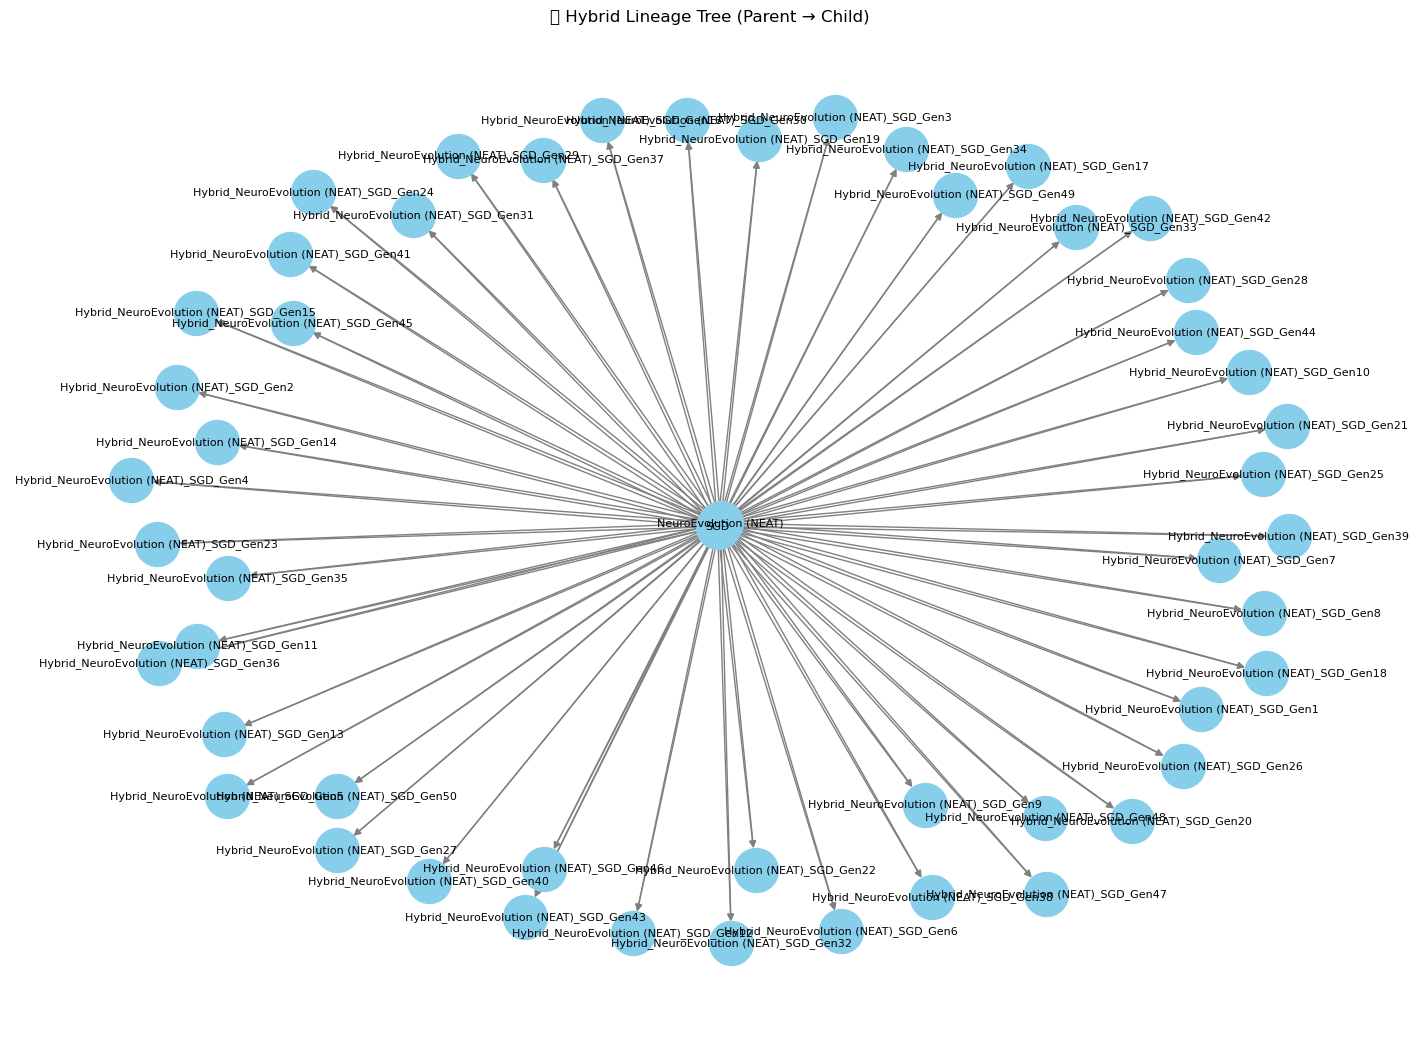

In [94]:
import matplotlib.pyplot as plt
import networkx as nx

# ✅ Convert family tree dict into DataFrame
df_tree = pd.DataFrame([
    {"Child": child, "Parent1": data["parents"][0], "Parent2": data["parents"][1], "Generation": data["generation"]}
    for child, data in family_tree.items()
])

# ✅ Build and draw the lineage graph
G = nx.DiGraph()
for _, row in df_tree.iterrows():
    G.add_edge(row["Parent1"], row["Child"])
    G.add_edge(row["Parent2"], row["Child"])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", edge_color="gray", font_size=8)
plt.title("🌳 Hybrid Lineage Tree (Parent → Child)")
plt.show()